In [10]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from torch.utils.data import DataLoader

from model import GraphNet
from utils import (
    DotDict,
    load_checkpoint,
    eval_model,
    load_and_split_dataset,
    process_datasets,
    shortest_tour,
)
from utils.data import (
    distance_from_adj_matrix,
)
from utils.plot import plot_graph, plot_heatmap, plot_beam_search_tour

sns.set_theme()

In [5]:
def get_data_filename(instance_size):
    if instance_size == 10:
        return "vrp_10_1s.pkl"

    if instance_size == 20:
        return "vrp_20_3s.pkl"

    if instance_size == 50:
        return "vrp_50_8s.pkl"

    raise ValueError("Invalid dataset size")


def load_dataloader(size):
    file_name = get_data_filename(size)
    _, test_dataset = process_datasets(
        load_and_split_dataset(f"data/{file_name}", test_size=0.05),
        k=6,
        special_connections=False,
        node_token=True,
    )

    print(f"Data loaded: {len(test_dataset)} samples for {size} nodes")

    return DataLoader(test_dataset, batch_size=100, shuffle=False)


def load_model(path):
    MODEL_PATH = Path("runs") / path

    checkpoint = load_checkpoint(MODEL_PATH / "last_epoch_model.pt")
    config = DotDict(checkpoint["config"])
    model = GraphNet(config, experimental=True).cpu()
    model.load_state_dict(checkpoint["model_state_dict"])

    return model, config

In [ ]:
def calculate_opt_gaps(test_dataloader, num_vehicles, model):
    print(f"Using {num_vehicles} vehicles")

    greedy_opt_gap = []
    shortest_opt_gap = []
    random_opt_gap = []

    for batch_features, batch_targets in test_dataloader:
        batch_node_features = batch_features["node_features"].cpu()
        batch_dist_matrix = batch_features["dist_matrix"].cpu()
        batch_edge_features = batch_features["edge_feat_matrix"].cpu()
        batch_targets = batch_targets.cpu()

        preds = eval_model(
            batch_node_features, batch_dist_matrix, batch_edge_features, model=model
        )
        random_preds = torch.rand(preds.shape)

        actual_distance = (
            distance_from_adj_matrix(batch_targets, batch_dist_matrix).cpu().numpy()
        )

        _, greedy_distances = most_probable_tour(
            preds, batch_dist_matrix, batch_node_features, num_vehicles=num_vehicles, beam_width=10
        )
        _, shortest_distances = shortest_tour(
            preds, batch_dist_matrix, batch_node_features, num_vehicles=num_vehicles, beam_width=1280,
            free_depot=True
        )
        _, random_distances = most_probable_tour(
            random_preds, batch_dist_matrix, batch_node_features, num_vehicles=num_vehicles, beam_width=10
        )

        greedy_opt_gap.extend(greedy_distances / actual_distance - 1)
        shortest_opt_gap.extend(shortest_distances / actual_distance - 1)
        random_opt_gap.extend(random_distances / actual_distance - 1)

    greedy_opt_gap = np.array(greedy_opt_gap)
    shortest_opt_gap = np.array(shortest_opt_gap)
    random_opt_gap = np.array(random_opt_gap)

    return greedy_opt_gap, shortest_opt_gap, random_opt_gap


def issues(*args):
    for opt in (args):
        print(f"inf: {np.isinf(opt).sum()} | <= 0: {np.sum(opt <= 0)}")

# Generalisation

In [ ]:
INSTANCE_SIZE = 10
model_path = Path(f"dims/exp_vrp{INSTANCE_SIZE}_dim_32_12_0.001_token_only")
model, _ = load_model(model_path)

for ds, vehicle in ((10, 4), (20, 5), (50, 10)):
    print(f"Dataset size: {ds}")
    test_dataloader = load_dataloader(ds)
    greedy_opt_gap, shortest_opt_gap, random_opt_gap = calculate_opt_gaps(test_dataloader, vehicle, model)

    issues(greedy_opt_gap, shortest_opt_gap, random_opt_gap)

    print(f"Greedy: {greedy_opt_gap.mean(where=~np.isinf(greedy_opt_gap)):.2%}")
    print(f"Shortest: {shortest_opt_gap.mean(where=~np.isinf(shortest_opt_gap)):.2%}")
    print(f"Random: {random_opt_gap.mean(where=~np.isinf(random_opt_gap)):.2%}")
    print()

In [ ]:
# for choice in rand_choices:
#     fig, ax = plt.subplots(1, 2, figsize=(8, 3))
#     sns.heatmap(batch_targets[choice].cpu().numpy(), ax=ax[0])
#     sns.heatmap(preds[choice, ..., 1].cpu().numpy(), ax=ax[1])
#
#     plt.show()

Compare two model predictions

In [ ]:
size = 20
dl = load_dataloader(size)
indices = np.random.choice(dl.batch_size, 20)

In [ ]:
model_a = Path(f"dims/exp_vrp{size}_dim_32_12_0.001_token_only")
model_b = Path(f"dims/exp_vrp{size}_dim_64_12_0.001_token_only")

batch_features, batch_targets = next(iter(dl))
batch_node_features = batch_features["node_features"].cpu()
batch_dist_matrix = batch_features["dist_matrix"].cpu()
batch_edge_features = batch_features["edge_feat_matrix"].cpu()

batch_targets = batch_targets.cpu().numpy()

for i in indices:
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    plot_graph(batch_node_features[i, :, :2].numpy(), batch_targets[i], ax=ax[0])

    for m, model_path in enumerate((model_a, model_b)):
        model, config = load_model(model_path)

        preds = eval_model(
            batch_node_features, batch_dist_matrix, batch_edge_features, model=model
        )
        preds = preds[..., 1].cpu().numpy()

        _ax = ax[m + 1]
        plot_heatmap(batch_node_features[i, :, :2].numpy(), batch_targets[i], preds[i], ax=_ax)
        _ax.set_title(f"Model {str(model_path).split('/')[-1]}")

    fig.tight_layout()
    plt.show()

In [116]:
viz = Path("plots/visualisations")
viz.mkdir(exist_ok=True)

size = 50
dl = load_dataloader(size)
model_path = Path(f"dims/exp_vrp{size}_dim_32_12_0.001_token_only")
model, config = load_model(model_path)

Data loaded: 500 samples for 50 nodes


In [117]:
batch_features, batch_targets = next(iter(dl))
batch_node_features = batch_features["node_features"].cpu()
batch_dist_matrix = batch_features["dist_matrix"].cpu()
batch_edge_features = batch_features["edge_feat_matrix"].cpu()
batch_targets = batch_targets.cpu()

preds = eval_model(
    batch_node_features, batch_dist_matrix, batch_edge_features, model=model
)

In [118]:
actual_distance = distance_from_adj_matrix(batch_targets, batch_dist_matrix)
# greedy_routes, greedy_distances = most_probable_tour(
#     preds,
#     batch_dist_matrix,
#     batch_node_features,
#     num_vehicles=config.num_vehicles,
#     beam_width=10,
# )
routes, shortest_distances = shortest_tour(
    preds,
    batch_dist_matrix,
    batch_node_features,
    num_vehicles=config.num_vehicles,
    beam_width=1280,
)

actual_distance = actual_distance.cpu().numpy()
node_features = batch_node_features.cpu().numpy()
targets = batch_targets.cpu().numpy()
predictions = preds[..., 1].cpu().numpy()

In [119]:
opt_gap = (shortest_distances - actual_distance) / actual_distance
cnt = np.isinf(opt_gap).sum()
sorts = np.argsort(opt_gap)

In [120]:
cnt

61

In [127]:
rand_choices = np.random.choice(sorts[:-cnt], 5, replace=False)

In [128]:
from utils.plot import edge_pred_to_edge_list, route_to_edge_list
import networkx as nx


def plot_graph(nodes, adj_matrix, ax=None):
    """
    Plots the graph.
    :param nodes: locations of the nodes
    :param adj_matrix: adjacency matrix
    :param ax: matplotlib axis
    :return:
    """
    G = nx.from_numpy_array(adj_matrix)
    pos = dict(enumerate(nodes))

    node_colours = ["tab:red"] + ["tab:blue"] * (len(nodes) - 1)

    nx.draw_networkx(G, pos, ax=ax, node_color=node_colours, node_size=50, with_labels=False)


def plot_heatmap(nodes, adj_matrix, prediction, ax=None):
    """
    Plots the graph with a heatmap of the edge predictions.
    :param nodes: locations of the nodes
    :param adj_matrix: adjacency matrix
    :param prediction: adjacency matrix prediction
    :param ax: matplotlib axis
    :return:
    """
    G = nx.from_numpy_array(adj_matrix)
    pos = dict(enumerate(nodes))

    edge_list, edge_values = edge_pred_to_edge_list(prediction)
    node_colours = ["tab:red"] + ["tab:blue"] * (len(nodes) - 1)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colours, node_size=50)
    # nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=edge_list,
        edge_color=edge_values,
        edge_cmap=sns.cm.flare,
        ax=ax,
    )


def plot_beam_search_tour(nodes, adj_matrix, route, ax=None):
    """
    Plots the graph with the beam search tour.
    :param nodes: locations of the nodes
    :param adj_matrix: adjacency matrix
    :param route: route
    :param ax: matplotlib axis
    :return:
    """
    G = nx.from_numpy_array(adj_matrix)
    pos = dict(enumerate(nodes))

    edge_list = route_to_edge_list(route)
    node_colours = ["tab:red"] + ["tab:blue"] * (len(nodes) - 1)

    nx.draw_networkx_nodes(G, pos, ax=ax, node_color=node_colours, node_size=50)
    # nx.draw_networkx_labels(G, pos, ax=ax)
    nx.draw_networkx_edges(G, pos, edgelist=edge_list, edge_cmap=sns.cm.flare, ax=ax)

Sample: 90


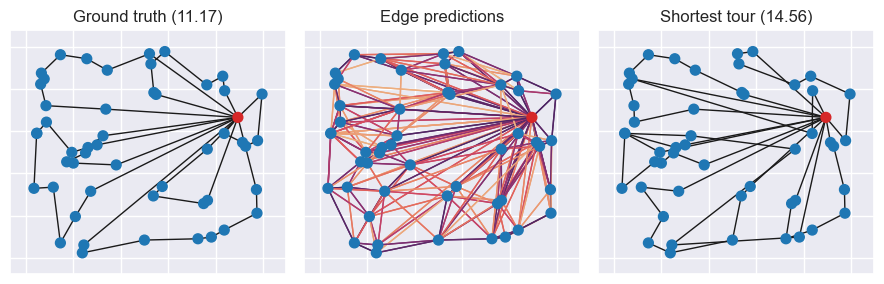

Sample: 77


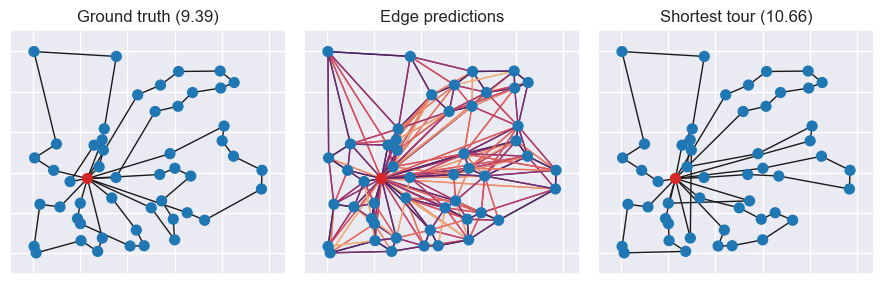

Sample: 59


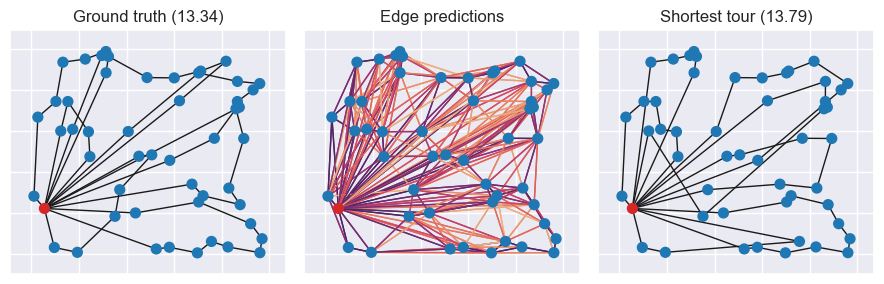

Sample: 21


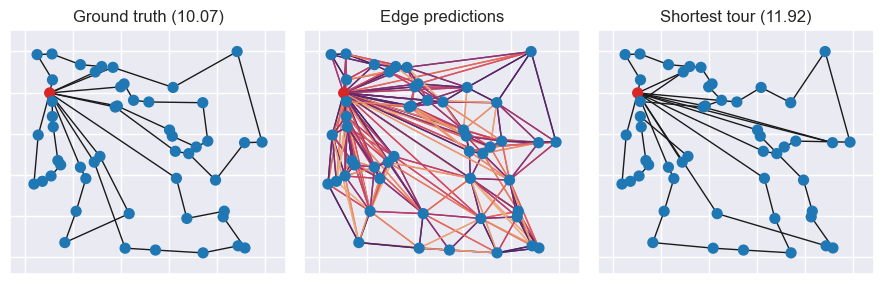

Sample: 86


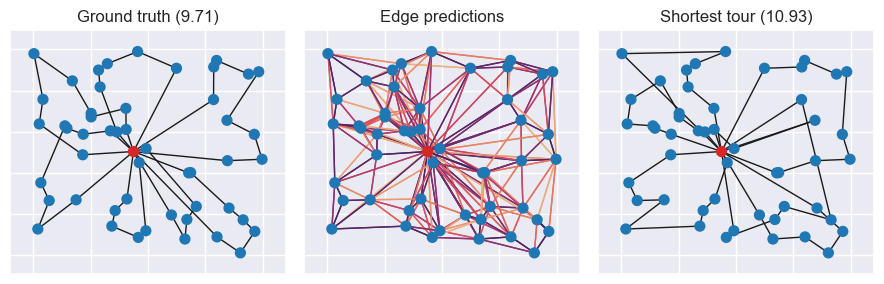

In [129]:
for i in rand_choices:
    print(f"Sample: {i}")
    fig, ax = plt.subplots(1, 3, figsize=(9, 3))

    plot_graph(node_features[i, :, :2], targets[i], ax=ax[0])
    plot_heatmap(node_features[i, :, :2], targets[i], predictions[i], ax=ax[1])
    plot_beam_search_tour(
        node_features[i, :, :2], targets[i], routes[i], ax=ax[2]
    )

    ax[0].set_title(f"Ground truth ({actual_distance[i]:.2f})")
    ax[1].set_title("Edge predictions")
    ax[2].set_title(f"Shortest tour ({shortest_distances[i]:.2f})")

    fig.tight_layout()
    plt.savefig(viz / f"vrp{size}_sample_{i}.png", dpi=150)
    plt.show()